**License:**

The data used in this project was collected by the Orthopaedics Department of the University Hospital Schleswig-Holstein (UKSH) in Kiel, Germany. Approval for the use of this data was granted by the department director, Prof. Dr. Babak Moradi.

# Portfolio Exam

## Story

Welcome to Therapiecenter Weinstadt, where we are pioneering a new project at the intersection of technology and human movement analysis. Our goal is ambitious: can we determine if someone is male or female simply by analyzing their gait?

To answer this question, we are developing a **Proof of Concept (POC)** that leverages advanced deep learning techniques. We begin by gathering data from approximately 90 individuals. Instead of traditional markers, we used a markerless camera system to track each subject’s movements with precision, capturing detailed angles for each joint over multiple gait cycles. Each subject walks on a treadmill, allowing us to record more than one gait cycle per person. This method enabled us to build a dataset with a smaller group of participants but with a broad range of motion data for each individual, offering us diverse insights into their movement patterns.

By analyzing these angles and joint positions across the gait cycles, we aim to discover, gender-related differences that may exist within the mechanics of human movement. This project is not only about classification but also about expanding our understanding of human biomechanics and how it can differ between individuals.

Starting with a POC helps us keep things manageable and allows us to refine our approach with a small, focused dataset. If successful, this POC could pave the way for more comprehensive studies in the future, allowing us to apply this knowledge in clinical, therapeutic, or even sports performance settings.

At Therapiecenter Weinstadt, we believe this project has the potential to open new doors in understanding and analyzing human gait in ways previously unexplored.

In [1]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter


# Display all columns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Google Colab

In [2]:

# mount drive
# from google.colab import drive
# drive.mount('/content/drive')

# data_raw = pd.read_json(r'/content/drive/MyDrive/HochschuleKiel/DeepLearning/Portfolio Exam/data/data_filtered.json', orient='records')

# Privat Computer

In [3]:
data_raw = pd.read_json(r'../data/data_filtered.json', orient='records')

## The Data

The dataset contains gait data collected from 89 unique subjects, each of whom walked on a treadmill in a controlled gait lab environment. During these sessions, each subject completed multiple gait cycles within approximately 30 seconds of walking. The aim of this data collection is to explore whether a deep learning model can distinguish between male and female subjects based solely on the features of an individual gait cycle. This project serves as a proof of concept for gender classification just a single gait cycle from a human gait. In the file `DataCollection.ipynb` is the first process of data collection, documented. In file `ScriptClasses.py` are helper functions stored, which are used for this project.

**Explanation of the Features:**
- `age`:             Age of the Subject
- `subject`:          Unuiqe ID of the Subject
- `sex`:              Gender of the Subject
- `created`:          Date of the Gait Analysis
- `cycle`:            Which Gait Cylce

**Following the Left and Right Angles in X, Y & Z Axis of:**
- `Ankle Angles`:     Reflects the range of motion in the ankle joint, measuring dorsiflexion and plantarflexion movements critical for balance and walking.
- `CenterOfMass_corr`: Represents the corrected position of the body's center of mass, which is essential for understanding stability and movement coordination.
- `Elbow Angles`: Measures the angle of flexion and extension at the elbow joint, indicating arm mobility and function.
- `Foot Pitch Angles`: Refers to the angle of the foot relative to the ground, particularly during the stance phase of walking, to analyze gait efficiency.
- `Foot Progression`: Describes the alignment of the foot in the direction of walking, showing toe-in or toe-out positioning in gait analysis.
- `Hip Angles`: Captures the hip joint’s range of motion, including flexion, extension, and rotation, essential for evaluating lower limb mobility.
- `Knee Angles`:  Reflects the angle between the thigh and lower leg, providing insight into knee flexion and extension during gait and other movements.
- `Pelvic Angles`: Measures the orientation of the pelvis, including tilt, obliquity, and rotation, important for assessing balance and posture.
- `Shoulder Angles`: Reflects the movement of the shoulder joint, including abduction, flexion, and extension, relevant for upper body function.
- `Thorax Angles`: Represents the movement of the thoracic spine and upper body posture, crucial for overall balance and body alignment.
- `Thorax_Lab Angles`: A lab-specific measurement of the thoracic angles, potentially adjusted for precise posture and movement analysis

**Further Information about the Joint Angles:**

The left and right joint angles are stored as lists of 101 values, representing the joint angles throughout a complete gait cycle, sampled from 0% to 100%.


In [4]:
display(data_raw.head(3))

age  subject   sex              created     cycle  \
0   19  sub-002  male  2024-05-29 12:27:14   cycle_1   
1   19  sub-002  male  2024-05-29 12:27:14  cycle_10   
2   19  sub-002  male  2024-05-29 12:27:14  cycle_11   

                                 Left Ankle Angles_X  \
0  [-2.768442, -3.496685, -4.069201, -4.462231, -...   
1  [-7.611665, -8.296784, -8.636337, -8.653679, -...   
2  [-4.634666, -5.02648, -5.340784, -5.544887, -5...   

                                 Left Ankle Angles_Y  \
0  [7.935368, 8.292075, 8.685886, 9.081171, 9.438...   
1  [6.345243, 6.41904, 6.53749, 6.682159, 6.82977...   
2  [7.019156, 7.207421, 7.360003, 7.428865, 7.382...   

                                 Left Ankle Angles_Z  \
0  [0.6022689999999999, 0.629934, 0.660829, 0.667...   
1  [0.015241, 1.130675, 2.046575, 2.656725, 2.912...   
2  [0.8590829999999999, 0.9442879999999999, 1.291...   

                            Left CenterOfMass_corr_X  \
0  [0.0, -0.002226, -0.00464, -0.0072429999999999...   
1  [0.016838, 0.015413, 0.013836999999999999, 0.0...   
2  [0.020581, 0.018594, 0.016465, 0.014183, 0.011...   

                            Left CenterOfMass_corr_Y  \
0  [0.0, -0.000268, -0.00040699999999999997, -0.0...   
1  [-0.009348, -0.009233, -0.008978, -0.008558, -...   
2  [-0.041350000000000005, -0.04147000000000001, ...   

                            Left CenterOfMass_corr_Z  \
0  [0.0, -0.001321, -0.0026279999999999997, -0.00...   
1  [0.000483, -0.001058, -0.002572, -0.004029, -0...   
2  [-0.002153, -0.003436, -0.004659, -0.005737, -...   

                                 Left Elbow Angles_X  \
0  [22.490803, 22.188433, 21.868492, 21.554268, 2...   
1  [22.925438, 22.503048, 22.122334, 21.826393, 2...   
2  [21.892666, 21.667431, 21.510859, 21.407866, 2...   

                                 Left Elbow Angles_Y  \
0  [-0.010251999999999999, -0.01488, -0.017207, -...   
1  [-0.019576, -0.016118999999999998, -0.01080699...   
2  [0.006052, 0.0068579999999999995, 0.0050479999...   

                                 Left Elbow Angles_Z  \
0  [104.20636, 103.466881, 102.595413, 101.67038,...   
1  [102.04879, 101.1464, 100.409393, 99.857368, 9...   
2  [103.10041, 103.414948, 103.769325, 104.036888...   

                            Left Foot Pitch Angles_X  \
0  [14.214731, 13.85244, 13.169363, 12.26093, 11....   
1  [12.341584, 12.335873, 12.083894, 11.615406, 1...   
2  [13.801257, 13.364927, 12.614091, 11.681816, 1...   

                            Left Foot Pitch Angles_Y  \
0  [-3.179904, -3.617692, -4.20662, -4.875635, -5...   
1  [-5.800112, -5.918781, -6.172589, -6.485641, -...   
2  [-7.515644, -7.981946, -8.420057, -8.740601999...   

                            Left Foot Pitch Angles_Z  \
0  [19.032904, 18.2679, 17.341208, 16.317291, 15....   
1  [26.423983, 25.275766, 23.834427, 22.164652, 2...   
2  [19.812559, 19.102261, 18.223965, 17.228157, 1...   

                             Left Foot Progression_X  \
0  [14.214735, 13.852443, 13.169367, 12.260934, 1...   
1  [12.341588, 12.335876, 12.083896, 11.615409, 1...   
2  [13.801261, 13.36493, 12.614095, 11.681819, 10...   

                             Left Foot Progression_Y  \
0  [-3.179903, -3.61769, -4.206618, -4.875634, -5...   
1  [-5.80011, -5.918779, -6.172588, -6.485639, -6...   
2  [-7.515642, -7.981944, -8.420057, -8.740601999...   

                             Left Foot Progression_Z  \
0  [-19.032904, -18.2679, -17.341208, -16.317291,...   
1  [-26.423983, -25.275766, -23.834427, -22.16465...   
2  [-19.812559, -19.102261, -18.223965, -17.22815...   

                                   Left Hip Angles_X  \
0  [20.6766, 20.222738, 19.856031, 19.556093, 19....   
1  [20.424934, 19.962803, 19.509947, 19.021643, 1...   
2  [21.490784, 21.206192, 20.810915, 20.239679, 1...   

                                   Left Hip Angles_Y  \
0  [-4.393382, -4.227548, -4.138162, -4.11265, -4...   
1  [-1.797753, -1.688857, -1.708179, -1.814137999...   
2  [-1.003

## Initial Data Analysis

Now we take a closer look at the data.

As we can see we have over 3600 gait cylces and 71 features. None of those features contain missing values.

We can also observe that the columns are not equally, which means that for some gait cylces the measurement could not be tracked/calculated or contained missing/Nan values and got cleaned beforehand. Subject 69 has the most gait cycles in the data. Female is the most present gender in the data. On the 08-08-2023 the most gait cycles where captured. Cycle 01 is most present in the data.

From the age column, we observe that the average age of the subjects is 54.34 years, with a standard deviation of 24.61. Ages range from a minimum of 0 to a maximum of 93 years. The majority of subjects fall within the age range of 30 to 74 years. The minimum age of 0 suggests the presence of outliers, which we will address during data preprocessing by removing these entries.

In [5]:
print(f'Shape of the data: {data_raw.shape}')
display(data_raw.info())
display(data_raw.describe(include='object'))
display(data_raw.describe(include='number'))

Shape of the data: (3656, 71)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 71 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3656 non-null   int64 
 1   subject                    3656 non-null   object
 2   sex                        3656 non-null   object
 3   created                    3656 non-null   object
 4   cycle                      3656 non-null   object
 5   Left Ankle Angles_X        3656 non-null   object
 6   Left Ankle Angles_Y        3656 non-null   object
 7   Left Ankle Angles_Z        3656 non-null   object
 8   Left CenterOfMass_corr_X   3656 non-null   object
 9   Left CenterOfMass_corr_Y   3656 non-null   object
 10  Left CenterOfMass_corr_Z   3656 non-null   object
 11  Left Elbow Angles_X        3656 non-null   object
 12  Left Elbow Angles_Y        3656 non-null   object
 13  Left Elbow Angles_Z        3656 n

None

subject     sex              created    cycle  \
count      3656    3656                 3656     3656   
unique       89       2                   91      137   
top     sub-069  female  2023-08-08 12:44:55  cycle_1   
freq        134    1930                  134      112   

                                      Left Ankle Angles_X  \
count                                                3656   
unique                                               2921   
top     [6.893189, 6.573399, 6.306869, 6.095495, 5.940...   
freq                                                    3   

                                      Left Ankle Angles_Y  \
count                                                3656   
unique                                               2921   
top     [2.444143, 2.506672, 2.569635, 2.63392, 2.6998...   
freq                                                    3   

                                      Left Ankle Angles_Z  \
count                                                3656   
unique                                               2921   
top     [11.521898, 11.749121, 12.024985, 12.331873, 1...   
freq                                                    3   

                                 Left CenterOfMass_corr_X  \
count                                                3656   
unique                                               2004   
top     [0.011529, 0.011380999999999999, 0.01116799999...   
freq                                                    3   

                                 Left CenterOfMass_corr_Y  \
count                                                3656   
unique                                               2004   
top     [-0.010992, -0.011198, -0.011365, -0.011496, -...   
freq                                                    3   

                                 Left CenterOfMass_corr_Z  \
count                                                3656   
unique                                               2004   
top     [0.006470000000000001, 0.005605, 0.004847, 0.0...   
freq                                                    3   

                                      Left Elbow Angles_X  \
count                                                3656   
unique                                               2921   
top     [67.722382, 67.841942, 67.953278, 68.052673, 6...   
freq                                                    3   

                                      Left Elbow Angles_Y  \
count                                                3656   
unique                                               2921   
top     [0.01161, 0.008588, 0.005424, 0.00264499999999...   
freq                                                    3   

                                      Left Elbow Angles_Z  \
count                                                3656   
unique                                               2921   
top     [67.336884, 67.013924, 66.85788, 66.890991, 67...   
freq                                                    3   

                                 Left Foot Pitch Angles_X  \
count                                                3656   
unique                                               2921   
top     [4.156376, 4.098315, 3.997932, 3.86376, 3.7056...   
freq                                                    3   

                                 Left Foot Pitch Angles_Y  \
count                                                3656   
unique                                               2921   
top     [-3.6453759999999997, -3.7622679999999997, -3....   
freq                                                    3   

                                 Left Foot Pitch Angles_Z  \
count                                                3656   
unique                                               2921   
top     [-1.318557, -1.5197289999999999, -1.7227109999...   
freq                                                    3   

                                  Left Foot Progre

age
count  3656.000000
mean     54.342177
std      24.618695
min       0.000000
25%      30.000000
50%      62.000000
75%      74.000000
max      93.000000

## Preprocessing

In the following chapter we preprocess the data.

In [6]:
display(data_raw.head(2))

age  subject   sex              created     cycle  \
0   19  sub-002  male  2024-05-29 12:27:14   cycle_1   
1   19  sub-002  male  2024-05-29 12:27:14  cycle_10   

                                 Left Ankle Angles_X  \
0  [-2.768442, -3.496685, -4.069201, -4.462231, -...   
1  [-7.611665, -8.296784, -8.636337, -8.653679, -...   

                                 Left Ankle Angles_Y  \
0  [7.935368, 8.292075, 8.685886, 9.081171, 9.438...   
1  [6.345243, 6.41904, 6.53749, 6.682159, 6.82977...   

                                 Left Ankle Angles_Z  \
0  [0.6022689999999999, 0.629934, 0.660829, 0.667...   
1  [0.015241, 1.130675, 2.046575, 2.656725, 2.912...   

                            Left CenterOfMass_corr_X  \
0  [0.0, -0.002226, -0.00464, -0.0072429999999999...   
1  [0.016838, 0.015413, 0.013836999999999999, 0.0...   

                            Left CenterOfMass_corr_Y  \
0  [0.0, -0.000268, -0.00040699999999999997, -0.0...   
1  [-0.009348, -0.009233, -0.008978, -0.008558, -...   

                            Left CenterOfMass_corr_Z  \
0  [0.0, -0.001321, -0.0026279999999999997, -0.00...   
1  [0.000483, -0.001058, -0.002572, -0.004029, -0...   

                                 Left Elbow Angles_X  \
0  [22.490803, 22.188433, 21.868492, 21.554268, 2...   
1  [22.925438, 22.503048, 22.122334, 21.826393, 2...   

                                 Left Elbow Angles_Y  \
0  [-0.010251999999999999, -0.01488, -0.017207, -...   
1  [-0.019576, -0.016118999999999998, -0.01080699...   

                                 Left Elbow Angles_Z  \
0  [104.20636, 103.466881, 102.595413, 101.67038,...   
1  [102.04879, 101.1464, 100.409393, 99.857368, 9...   

                            Left Foot Pitch Angles_X  \
0  [14.214731, 13.85244, 13.169363, 12.26093, 11....   
1  [12.341584, 12.335873, 12.083894, 11.615406, 1...   

                            Left Foot Pitch Angles_Y  \
0  [-3.179904, -3.617692, -4.20662, -4.875635, -5...   
1  [-5.800112, -5.918781, -6.172589, -6.485641, -...   

                            Left Foot Pitch Angles_Z  \
0  [19.032904, 18.2679, 17.341208, 16.317291, 15....   
1  [26.423983, 25.275766, 23.834427, 22.164652, 2...   

                             Left Foot Progression_X  \
0  [14.214735, 13.852443, 13.169367, 12.260934, 1...   
1  [12.341588, 12.335876, 12.083896, 11.615409, 1...   

                             Left Foot Progression_Y  \
0  [-3.179903, -3.61769, -4.206618, -4.875634, -5...   
1  [-5.80011, -5.918779, -6.172588, -6.485639, -6...   

                             Left Foot Progression_Z  \
0  [-19.032904, -18.2679, -17.341208, -16.317291,...   
1  [-26.423983, -25.275766, -23.834427, -22.16465...   

                                   Left Hip Angles_X  \
0  [20.6766, 20.222738, 19.856031, 19.556093, 19....   
1  [20.424934, 19.962803, 19.509947, 19.021643, 1...   

                                   Left Hip Angles_Y  \
0  [-4.393382, -4.227548, -4.138162, -4.11265, -4...   
1  [-1.797753, -1.688857, -1.708179, -1.814137999...   

                                   Left Hip Angles_Z  \
0  [-0.280891, -1.543496, -2.484963, -3.042148, -...   
1  [-2.878228, -2.440343, -1.9427249999999998, -1...   

                                  Left Knee Angles_X  \
0  [2.135388, 1.461672, 1.318257, 1.61889, 2.2538...   
1  [2.762847, 1.953323, 1.724262, 1.937817, 2.447...   

                                  Left Knee Angles_Y  \
0  [-0.194929, -0.818533, -1.206393, -1.397462, -...   
1  [-0.236487, -0.9723259999999999, -1.39173, -1....   

                                  Left Knee Angles_Z  \
0  [-14.350356, -12.79824, -11.413175, -10.301519...   
1  [-18.446913, -19.233843, -19.68598, -19.714357...   

                                Left Pelvic Angles_X  \
0  [3.991429, 3.891927, 3.795211, 3.698814, 3.599...   
1  [1.090251, 0.818932, 0.5202, 0.200094, -0.1280...   

                                Left Pelvic Angles_Y  \
0  [-0.522435, -0.717429, -0.9033939999999999, -1...   
1  [

To identify the unique subject at the unique time, we combine the features 'subject' and 'created'.

In [7]:
data_raw['session_name'] = data_raw['subject'] + '_' + data_raw['created']

Then we can drop the columns 'subject' and 'created'

In [8]:
data_raw.drop(['subject', 'created'], axis=1, inplace=True)

Next we check if the lists in the angle columns have nan values and have the same length of 101.

In [9]:
cols = data_raw.columns.tolist()
col_to_check = cols[4:] # check all columns with the angles
# Überprüfen, ob alle Listen die gleiche Länge haben
lengths = data_raw[col_to_check].map(len)
print(lengths.value_counts())

# Konvertieren aller Listen in numpy-Arrays
data_raw[col_to_check] = data_raw[col_to_check].map(lambda x: np.array(x) if isinstance(x, list) else x)

# Überprüfen, ob es NaN-Werte in den Listen gibt
nan_counts = data_raw[col_to_check].map(lambda x: np.isnan(x).any() if isinstance(x, np.ndarray) else False)
print(nan_counts.value_counts())


Left Ankle Angles_Y  Left Ankle Angles_Z  Left CenterOfMass_corr_X  Left CenterOfMass_corr_Y  Left CenterOfMass_corr_Z  Left Elbow Angles_X  Left Elbow Angles_Y  Left Elbow Angles_Z  Left Foot Pitch Angles_X  Left Foot Pitch Angles_Y  Left Foot Pitch Angles_Z  Left Foot Progression_X  Left Foot Progression_Y  Left Foot Progression_Z  Left Hip Angles_X  Left Hip Angles_Y  Left Hip Angles_Z  Left Knee Angles_X  Left Knee Angles_Y  Left Knee Angles_Z  Left Pelvic Angles_X  Left Pelvic Angles_Y  Left Pelvic Angles_Z  Left Shoulder Angles_X  Left Shoulder Angles_Y  Left Shoulder Angles_Z  Left Thorax Angles_X  Left Thorax Angles_Y  Left Thorax Angles_Z  Left Thorax_Lab Angles_X  Left Thorax_Lab Angles_Y  Left Thorax_Lab Angles_Z  Right Ankle Angles_X  Right Ankle Angles_Y  Right Ankle Angles_Z  Right CenterOfMass_corr_X  Right CenterOfMass_corr_Y  Right CenterOfMass_corr_Z  Right Elbow Angles_X  Right Elbow Angles_Y  Right Elbow Angles_Z  Right Foot Pitch Angles_X  Right Foot Pitch Angles_Y

Next we do some feature engineering and calculate the age of each subject.

In [10]:
# bring the last column to the first position
cols = data_raw.columns.tolist()
cols = cols[-1:] + cols[:-1]
data_raw = data_raw[cols]
display(data_raw.head(3))


session_name  age   sex     cycle  \
0  sub-002_2024-05-29 12:27:14   19  male   cycle_1   
1  sub-002_2024-05-29 12:27:14   19  male  cycle_10   
2  sub-002_2024-05-29 12:27:14   19  male  cycle_11   

                                 Left Ankle Angles_X  \
0  [-2.768442, -3.496685, -4.069201, -4.462231, -...   
1  [-7.611665, -8.296784, -8.636337, -8.653679, -...   
2  [-4.634666, -5.02648, -5.340784, -5.544887, -5...   

                                 Left Ankle Angles_Y  \
0  [7.935368, 8.292075, 8.685886, 9.081171, 9.438...   
1  [6.345243, 6.41904, 6.53749, 6.682159, 6.82977...   
2  [7.019156, 7.207421, 7.360003, 7.428865, 7.382...   

                                 Left Ankle Angles_Z  \
0  [0.6022689999999999, 0.629934, 0.660829, 0.667...   
1  [0.015241, 1.130675, 2.046575, 2.656725, 2.912...   
2  [0.8590829999999999, 0.9442879999999999, 1.291...   

                            Left CenterOfMass_corr_X  \
0  [0.0, -0.002226, -0.00464, -0.0072429999999999...   
1  [0.016838, 0.015413, 0.013836999999999999, 0.0...   
2  [0.020581, 0.018594, 0.016465, 0.014183, 0.011...   

                            Left CenterOfMass_corr_Y  \
0  [0.0, -0.000268, -0.00040699999999999997, -0.0...   
1  [-0.009348, -0.009233, -0.008978, -0.008558, -...   
2  [-0.041350000000000005, -0.04147000000000001, ...   

                            Left CenterOfMass_corr_Z  \
0  [0.0, -0.001321, -0.0026279999999999997, -0.00...   
1  [0.000483, -0.001058, -0.002572, -0.004029, -0...   
2  [-0.002153, -0.003436, -0.004659, -0.005737, -...   

                                 Left Elbow Angles_X  \
0  [22.490803, 22.188433, 21.868492, 21.554268, 2...   
1  [22.925438, 22.503048, 22.122334, 21.826393, 2...   
2  [21.892666, 21.667431, 21.510859, 21.407866, 2...   

                                 Left Elbow Angles_Y  \
0  [-0.010251999999999999, -0.01488, -0.017207, -...   
1  [-0.019576, -0.016118999999999998, -0.01080699...   
2  [0.006052, 0.0068579999999999995, 0.0050479999...   

                                 Left Elbow Angles_Z  \
0  [104.20636, 103.466881, 102.595413, 101.67038,...   
1  [102.04879, 101.1464, 100.409393, 99.857368, 9...   
2  [103.10041, 103.414948, 103.769325, 104.036888...   

                            Left Foot Pitch Angles_X  \
0  [14.214731, 13.85244, 13.169363, 12.26093, 11....   
1  [12.341584, 12.335873, 12.083894, 11.615406, 1...   
2  [13.801257, 13.364927, 12.614091, 11.681816, 1...   

                            Left Foot Pitch Angles_Y  \
0  [-3.179904, -3.617692, -4.20662, -4.875635, -5...   
1  [-5.800112, -5.918781, -6.172589, -6.485641, -...   
2  [-7.515644, -7.981946, -8.420057, -8.740601999...   

                            Left Foot Pitch Angles_Z  \
0  [19.032904, 18.2679, 17.341208, 16.317291, 15....   
1  [26.423983, 25.275766, 23.834427, 22.164652, 2...   
2  [19.812559, 19.102261, 18.223965, 17.228157, 1...   

                             Left Foot Progression_X  \
0  [14.214735, 13.852443, 13.169367, 12.260934, 1...   
1  [12.341588, 12.335876, 12.083896, 11.615409, 1...   
2  [13.801261, 13.36493, 12.614095, 11.681819, 10...   

                             Left Foot Progression_Y  \
0  [-3.179903, -3.61769, -4.206618, -4.875634, -5...   
1  [-5.80011, -5.918779, -6.172588, -6.485639, -6...   
2  [-7.515642, -7.981944, -8.420057, -8.740601999...   

                             Left Foot Progression_Z  \
0  [-19.032904, -18.2679, -17.341208, -16.317291,...   
1  [-26.423983, -25.275766, -23.834427, -22.16465...   
2  [-19.812559, -19.102261, -18.223965, -17.22815...   

                                   Left Hip Angles_X  \
0  [20.6766, 20.222738, 19.856031, 19.556093, 19....   
1  [20.424934, 19.962803, 19.509947, 19.021643, 1...   
2  [21.490784, 21.206192, 20.810915, 20.239679, 1...   

                                   Left Hip Angles_Y  \
0  [-4.393382, -4.227548, -4.138162, -4.11265, -4...   
1  [-1.797753, -1.688857, -1.708179, -1.814137999...   
2  [-1.003782, -1.046244, -1.

In [11]:
df_age = data_raw.groupby(by=['sex', 'session_name']).agg({'age': 'first'}).reset_index().sort_values(by=['sex', 'age'])
display(df_age.describe())

age
count  91.000000
mean   52.450549
std    23.708069
min     0.000000
25%    29.000000
50%    58.000000
75%    72.500000
max    93.000000

As we observe, that we have 91 subjects. The maximum age is 93 years old and the minimum age is 0 years old, resulting that we have to drop out outliers.

We consider subjects younger then 5 years old as outlier.

In [12]:
print(f'Shape before filter: {data_raw.shape}')
data_raw = data_raw.loc[data_raw['age'] >= 5]
print(f'Shape after filter: {data_raw.shape}')

Shape before filter: (3656, 70)
Shape after filter: (3471, 70)


## Exploritory Data Analysis

### Age Distribution for each Gender

count    3471.000000
mean       57.238548
std        21.738467
min         6.000000
25%        39.000000
50%        63.000000
75%        74.000000
max        93.000000
Name: age, dtype: float64

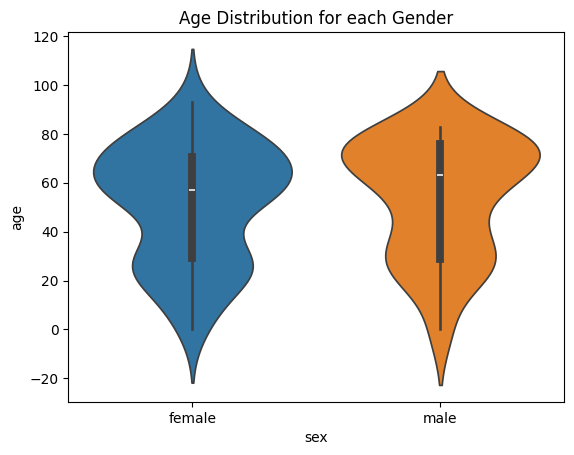

In [13]:
display(data_raw.age.describe())
sns.violinplot(df_age, x='sex', y='age', hue='sex')
plt.title('Age Distribution for each Gender')
plt.show()

- The dataset consists of 3471 gait cylces with an average age of the subjects of approximately 57.2 years.

- The age standard deviation is 21.7, reflecting a wide range of ages within the dataset.

- Ages range from a minimum of 6 years to a maximum of 93 years.

- The 25th percentile age is 39 years, the median age (50th percentile) is 63 years, and the 75th percentile is 74 years, indicating that most ages are concentrated between 39 and 74 years.

- There are no substantial visual differences between the male and female age distributions, as both display similar shapes and spreads.

- The female age distribution shows a slightly greater spread toward older ages compared to the male group.

### Gait Cycles Females and Males

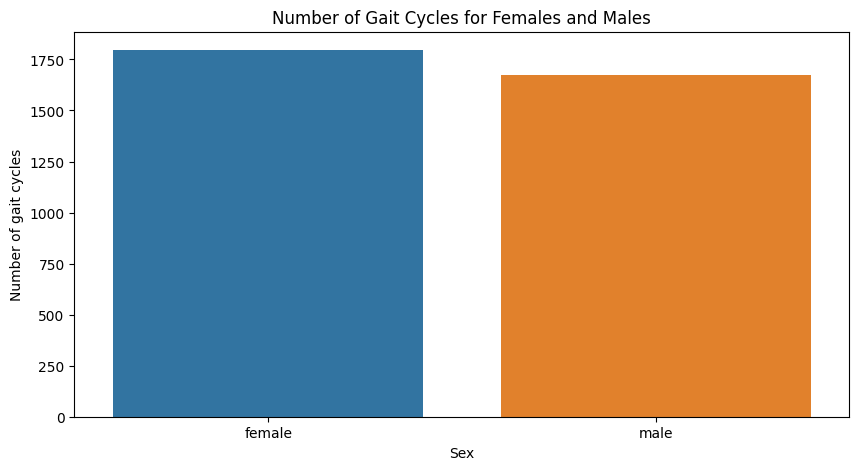

In [14]:
df_plot = data_raw.groupby(by=['sex']).agg({'session_name': 'count'}).reset_index()

fig = plt.figure(figsize=(10, 5))

sns.barplot(df_plot, x='sex', y='session_name', hue='sex')

# set title
plt.title('Number of Gait Cycles for Females and Males')
plt.ylabel('Number of gait cycles')
plt.xlabel('Sex')
plt.show()

We can observe that we have slightly more female subjects then male subjects in the data.  This indicates that we have unbalanced target.

### Angles in Gait Cylces

Next, we visually examine whether there are observable differences in walking patterns between males and females based on joint angles.

In [15]:
def get_mean_std(data: pd.DataFrame, joint_name: str, gender: str):
    """
    Calculates the mean and standard deviation of gait cycle values for a specified joint and gender.
    """
    matrix = []
    for row in data.loc[data['sex'] == gender][joint_name]:
        matrix.append(row)

    matrix = np.array(matrix)
    matrix.shape

    std = np.std(matrix, axis=0)
    mean = np.mean(matrix, axis=0)

    x = np.arange(0, len(mean))

    return x, mean, std


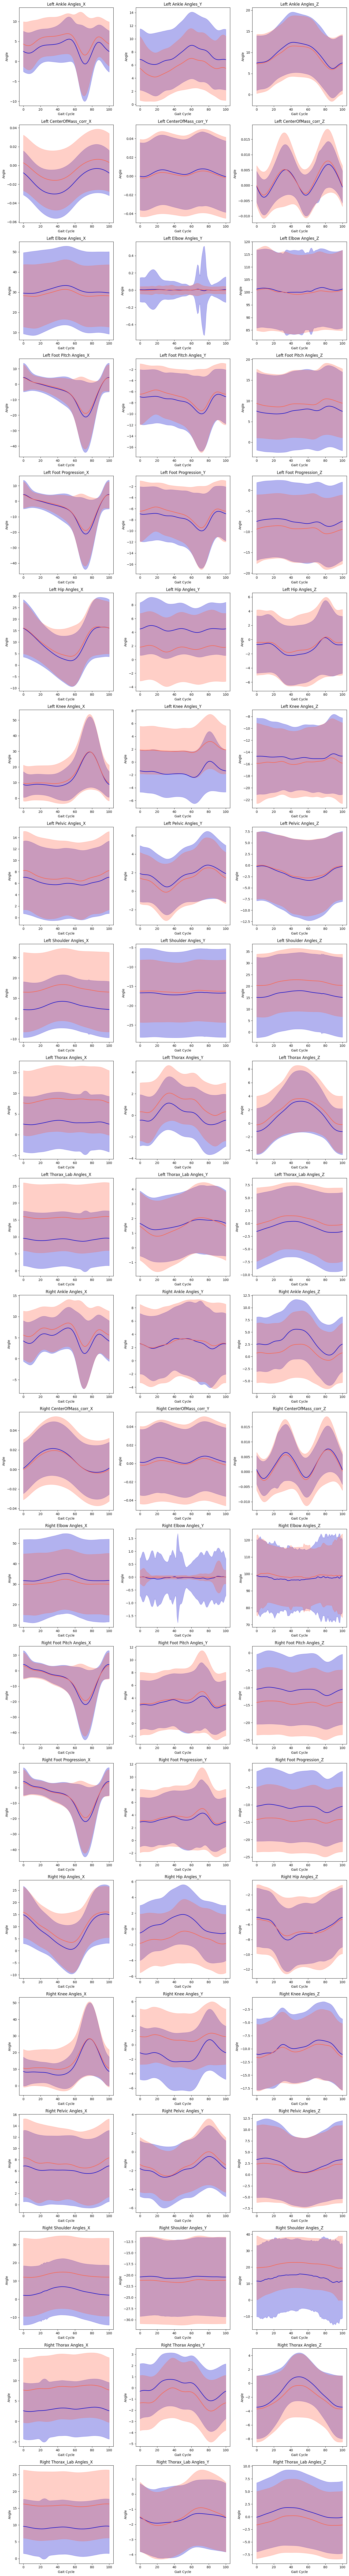

In [16]:
# Get all column names for the angles
colnames = data_raw.columns.tolist()[4:]

# groups of 3 columns for each joint (X, Y, Z)
joint_axes_groups = [
    colnames[i:i + 3] for i in range(0, len(colnames), 3)
]
n_rows = len(joint_axes_groups)  # number of joints
n_cols = 3  # X, Y, Z

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Plotting
for i, joint_axes in enumerate(joint_axes_groups):
    for j, col in enumerate(joint_axes):
        ax = axes[i, j]

        # Females
        color = 'mediumblue'
        x, mean, std = get_mean_std(data_raw, col, 'female')
        ax.plot(x, mean, color=color)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, color=color)

        # Males
        color = 'tomato'
        x, mean, std = get_mean_std(data_raw, col, 'male')
        ax.plot(x, mean, color=color)
        ax.fill_between(x, mean - std, mean + std, alpha=0.3, color=color)

        # Titel and labels
        ax.set_title(col)
        ax.set_xlabel('Gait Cycle')
        ax.set_ylabel('Angle')

plt.tight_layout()
plt.show()

**Observation:**

The plots reveal distinct differences in walking patterns between males and females, highlighted by variations in both average angles and standard deviations across nearly all joint features.

Males (in red) typically exhibit higher amplitude movements and more consistent patterns, particularly in the knee and ankle joints, suggesting greater range of motion and stability. In contrast, females (in blue) display more variability, especially in the knee and hip angles, along with slight asymmetries and timing differences. These patterns likely reflect underlying biomechanical differences, with males demonstrating a more stable, rhythmic gait and females showing subtle fluctuations and increased variability.

### Correlations

In [17]:
def get_matrix(data: pd.DataFrame, joint_name: str):
    """
    Calculates the mean and standard deviation of gait cycle values for a specified joint and gender.
    """
    matrix = []
    for row in data[joint_name]:
        matrix.append(row)

    matrix = np.array(matrix)


    return matrix


# Get all column names for the angles
colnames = data_raw.columns.tolist()[4:]

In [18]:
arrays = []
for col in colnames:
    matrix = get_matrix(data_raw, col)
    arrays.append(matrix)

# Stack arrays along a new dimension, resulting in a 3D array
stacked = np.stack(arrays, axis=0)
print(f'Shape of stacked array: {stacked.shape}')
print(stacked.reshape(len(stacked), -1).shape)

# Calculate element-wise correlation across the arrays
corr = np.corrcoef(stacked.reshape(len(stacked), -1))

Shape of stacked array: (66, 3471, 101)
(66, 350571)


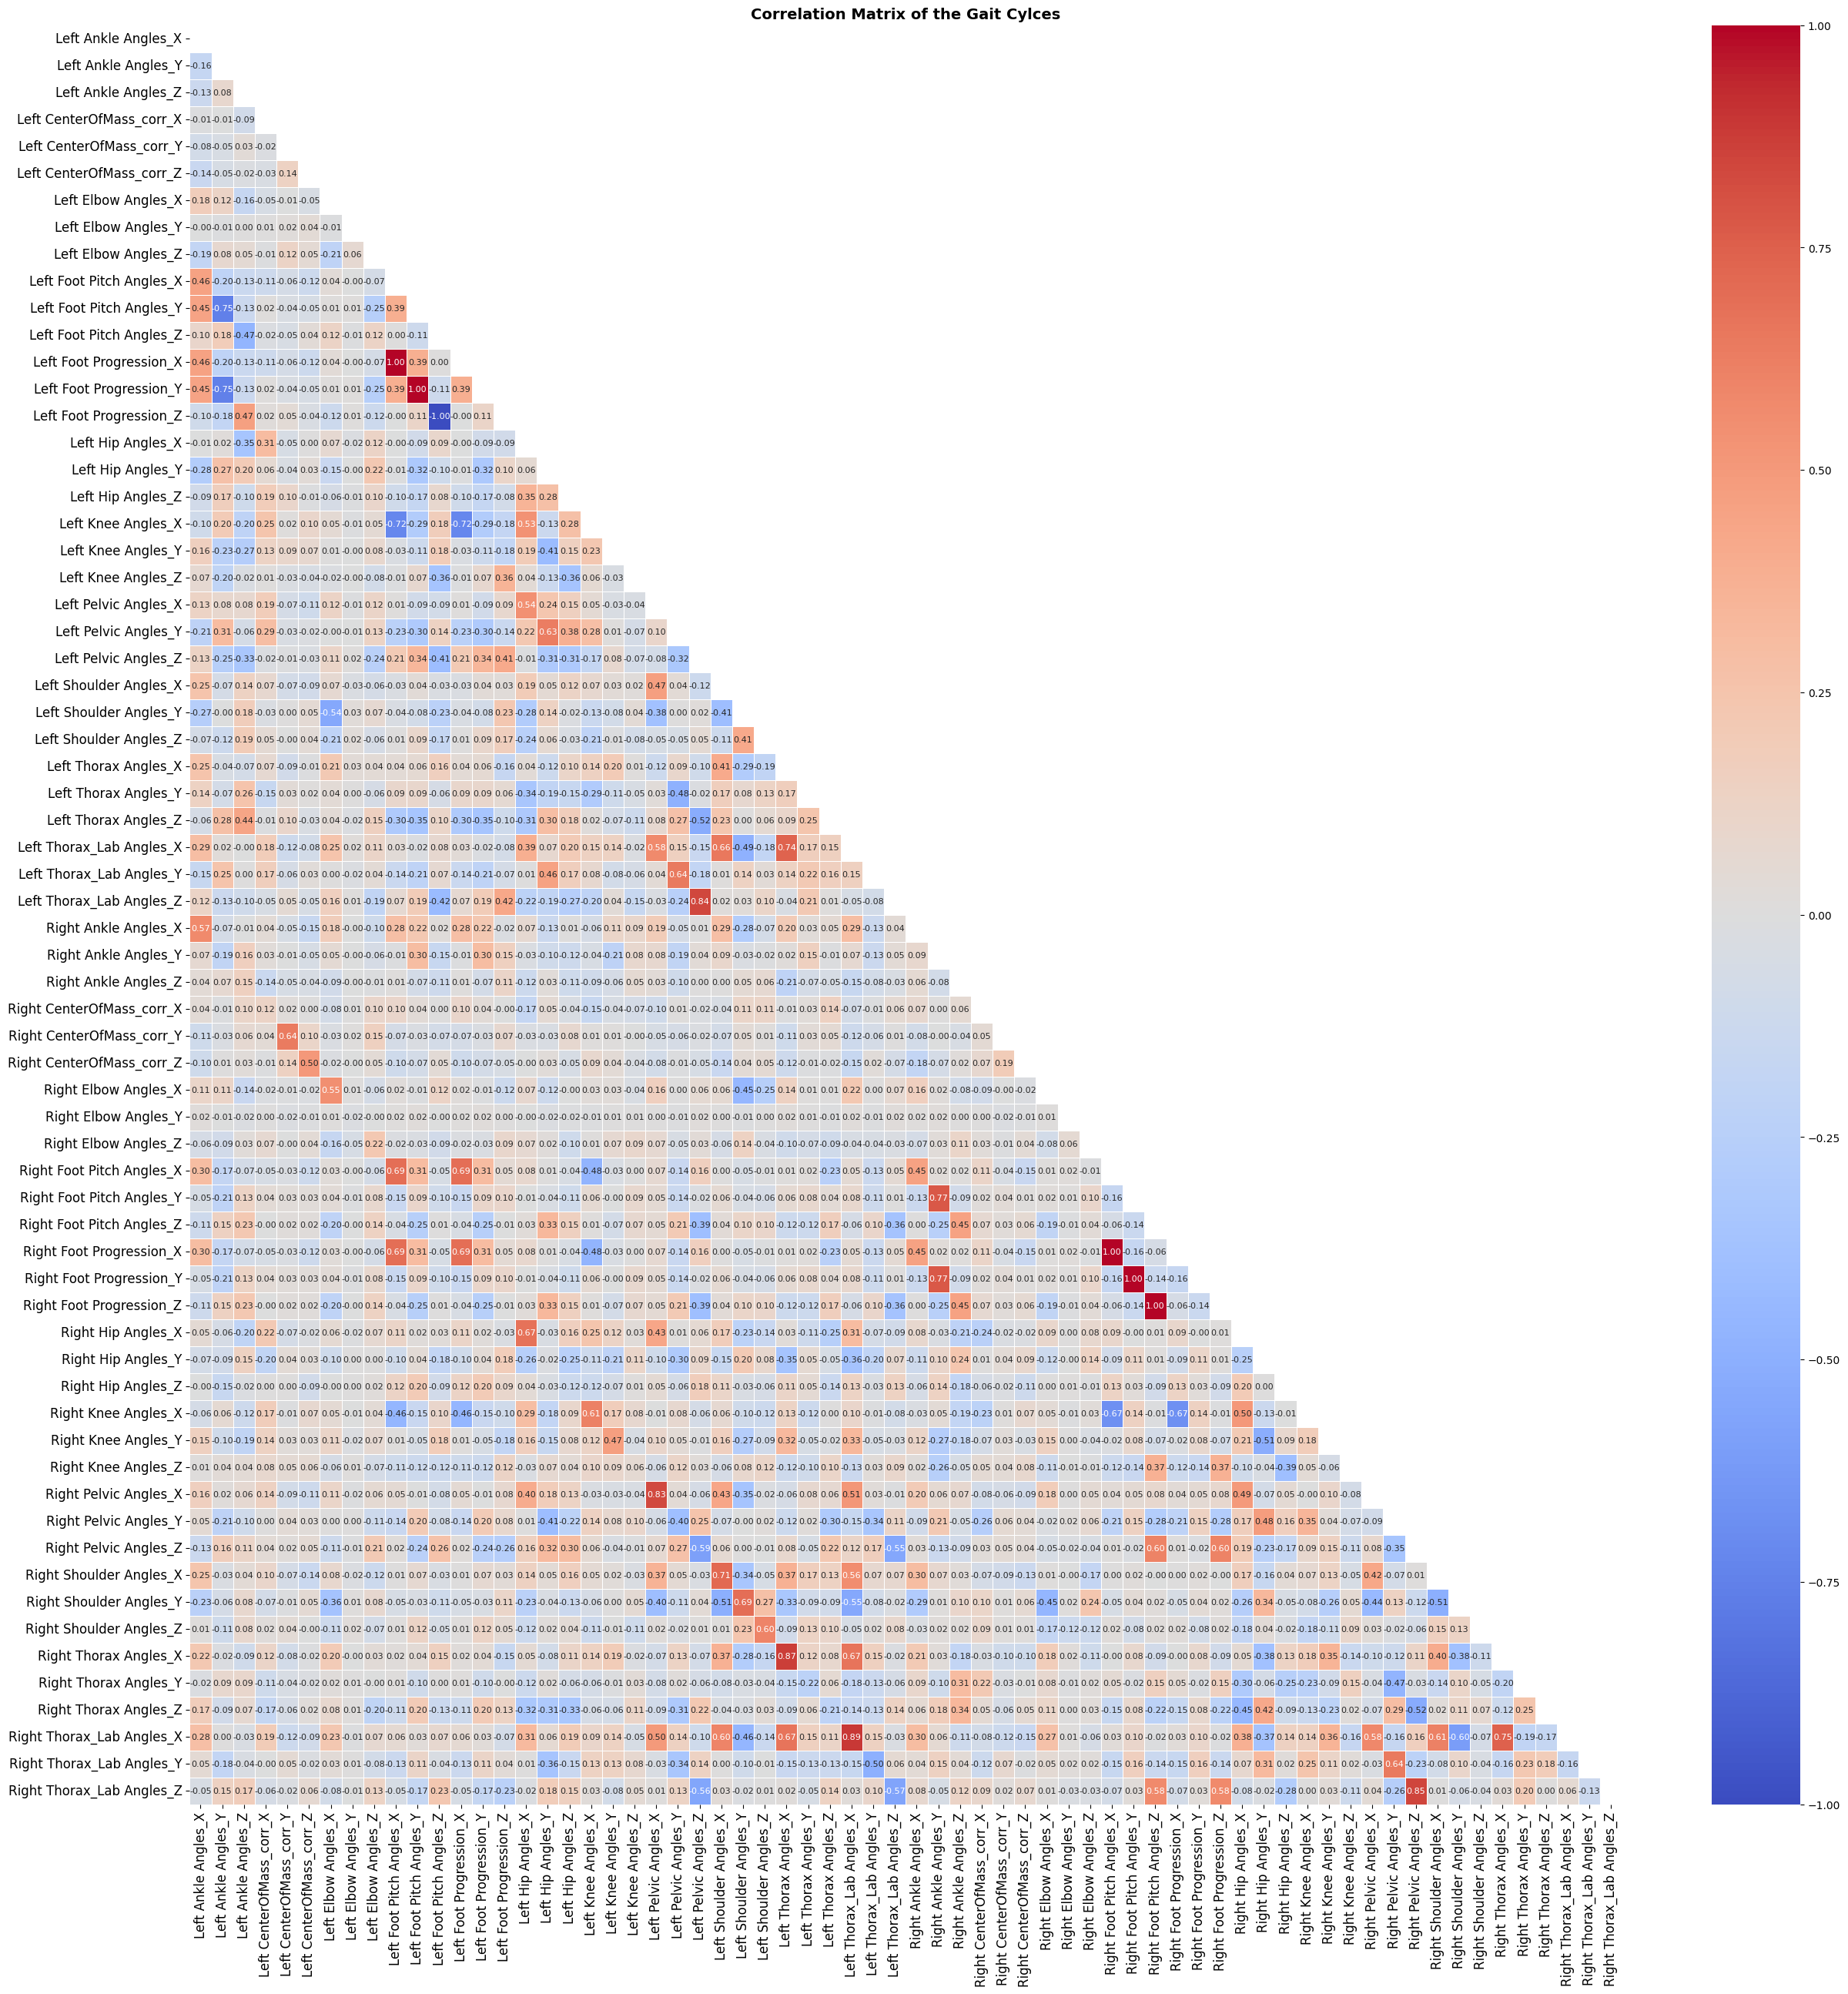

In [19]:
mask = np.triu(np.ones_like(corr, dtype=bool))  # Source: https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap

# Plot heatmap
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidth=0.5, fmt='.2f', annot_kws={"size": 8},
            mask=mask, vmin=-1, vmax=1,
            xticklabels=colnames, yticklabels=colnames
            )

plt.title('Correlation Matrix of the Gait Cylces', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12, rotation=0)
plt.show()

**Observations:**

- **Strong Positive Correlations**:
   - Certain joint angles or measurements appear to be strongly correlated with others, indicated by dark red cells. For example, the left and right thorax angles along various axes seem to have high positive correlations, which could reflect symmetrical movement patterns.
   - The **hip angles** and **knee angles** also show moderate to high positive correlations, suggesting that movement in these joints is coordinated during gait.

- **Symmetrical Patterns**:
   - The left and right counterparts for many body parts, like elbows, ankles, and shoulders, often show moderate to high correlations. This symmetry indicates that both sides of the body move in a coordinated manner, which is expected in a balanced gait cycle.
   
- **Negative Correlations**:
   - There are areas of strong negative correlation (dark blue cells), especially involving certain axes of shoulder, elbow, and pelvic movements. These could signify compensatory movements where one part of the body counterbalances the motion of another.
   - For example, specific shoulder angles may counterbalance thorax or pelvic motions to maintain stability during gait.
   
- **Less Correlated Features**:
   - Some variables, especially those related to more distant body parts (e.g., left foot angles and right shoulder angles), show low or near-zero correlations, suggesting these movements are more independent from each other.

- **Potential Redundancies**:
   - High correlations between similar metrics (e.g., progression and center of mass coordinates) imply that some measurements could be redundant. This could be useful if you're considering dimensionality reduction techniques like PCA to reduce the number of features while retaining most of the information.



---

## Baselines

### Preprocessing for the Models

For the upcomeing steps we process the data further. This is nececarry that the data is compatible for the models.

Next we define data and the targets for the following taks. We also map 1 for female and 0 for male, as those are the target values for the prediction.

In [20]:
target = data_raw['sex'] # define the target
target = target.map({'female': 1, 'male': 0}) # assign 1 for female and 1 for male
data = data_raw.drop(columns=['sex', 'session_name', 'cycle']) # drop the column sex, cylce and session_name from the data
data['age'] = data['age'].astype('int') # convert the age to integer

print('Data Head')
display(data.head(4))
print('Target Head')
display(target.head(4))
print(f'Shape of the data: {data.shape}')
print(f'Shape of the target: {target.shape}')

Data Head


age                                Left Ankle Angles_X  \
0   19  [-2.768442, -3.496685, -4.069201, -4.462231, -...   
1   19  [-7.611665, -8.296784, -8.636337, -8.653679, -...   
2   19  [-4.634666, -5.02648, -5.340784, -5.544887, -5...   
3   19  [-5.126583, -5.563317, -5.8677600000000005, -6...   

                                 Left Ankle Angles_Y  \
0  [7.935368, 8.292075, 8.685886, 9.081171, 9.438...   
1  [6.345243, 6.41904, 6.53749, 6.682159, 6.82977...   
2  [7.019156, 7.207421, 7.360003, 7.428865, 7.382...   
3  [5.791751, 5.315883, 4.801734, 4.333135, 4.000...   

                                 Left Ankle Angles_Z  \
0  [0.6022689999999999, 0.629934, 0.660829, 0.667...   
1  [0.015241, 1.130675, 2.046575, 2.656725, 2.912...   
2  [0.8590829999999999, 0.9442879999999999, 1.291...   
3  [-2.273809, -2.451972, -2.259908, -1.800332, -...   

                            Left CenterOfMass_corr_X  \
0  [0.0, -0.002226, -0.00464, -0.0072429999999999...   
1  [0.016838, 0.015413, 0.013836999999999999, 0.0...   
2  [0.020581, 0.018594, 0.016465, 0.014183, 0.011...   
3  [0.035844999999999995, 0.034800000000000005, 0...   

                            Left CenterOfMass_corr_Y  \
0  [0.0, -0.000268, -0.00040699999999999997, -0.0...   
1  [-0.009348, -0.009233, -0.008978, -0.008558, -...   
2  [-0.041350000000000005, -0.04147000000000001, ...   
3  [-0.069149, -0.068253, -0.067149, -0.065811, -...   

                            Left CenterOfMass_corr_Z  \
0  [0.0, -0.001321, -0.0026279999999999997, -0.00...   
1  [0.000483, -0.001058, -0.002572, -0.004029, -0...   
2  [-0.002153, -0.003436, -0.004659, -0.005737, -...   
3  [-0.002705, -0.003802, -0.00491, -0.005979, -0...   

                                 Left Elbow Angles_X  \
0  [22.490803, 22.188433, 21.868492, 21.554268, 2...   
1  [22.925438, 22.503048, 22.122334, 21.826393, 2...   
2  [21.892666, 21.667431, 21.510859, 21.407866, 2...   
3  [22.576475, 22.534582, 22.476358, 22.393591, 2...   

                                 Left Elbow Angles_Y  \
0  [-0.010251999999999999, -0.01488, -0.017207, -...   
1  [-0.019576, -0.016118999999999998, -0.01080699...   
2  [0.006052, 0.0068579999999999995, 0.0050479999...   
3  [-0.0009549999999999999, -0.001529, -0.0022589...   

                                 Left Elbow Angles_Z  \
0  [104.20636, 103.466881, 102.595413, 101.67038,...   
1  [102.04879, 101.1464, 100.409393, 99.857368, 9...   
2  [103.10041, 103.414948, 103.769325, 104.036888...   
3  [103.177101, 103.719116, 104.341812, 104.99225...   

                            Left Foot Pitch Angles_X  \
0  [14.214731, 13.85244, 13.169363, 12.26093, 11....   
1  [12.341584, 12.335873, 12.083894, 11.615406, 1...   
2  [13.801257, 13.364927, 12.614091, 11.681816, 1...   
3  [14.557133, 13.954084, 13.133732, 12.212157, 1...   

                            Left Foot Pitch Angles_Y  \
0  [-3.179904, -3.617692, -4.20662, -4.875635, -5...   
1  [-5.800112, -5.918781, -6.172589, -6.485641, -...   
2  [-7.515644, -7.981946, -8.420057, -8.740601999...   
3  [-7.865427, -7.826179, -7.720717, -7.581029, -...   

                            Left Foot Pitch Angles_Z  \
0  [19.032904, 18.2679, 17.341208, 16.317291, 15....   
1  [26.423983, 25.275766, 23.834427, 22.164652, 2...   
2  [19.812559, 19.102261, 18.223965, 17.228157, 1...   
3  [24.515747, 23.884928, 22.725981, 21.184366, 1...   

                             Left Foot Progression_X  \
0  [14.214735, 13.852443, 13.169367, 12.260934, 1...   
1  [12.341588, 12.335876, 12.083896, 11.615409, 1...   
2  [13.801261, 13.36493, 12.614095, 11.681819, 10...   
3  [14.557137, 13.954086, 13.133736, 12.21216, 11...   

                             Left Foot Progression_Y  \
0  [-3.179903, -3.61769, -4.206618, -4.875634, -5...   
1  [-5.80011, -5.918779, -6.172588, -6.485639, -6...   
2  [-7.515642, -7.981944, -8.420057, -8.740601999...   
3  [-7.865425, -7.8261769999999995, -7.7207159999...   

                             Left Foot Progr

Target Head


0    0
1    0
2    0
3    0
Name: sex, dtype: int64

Shape of the data: (3471, 67)
Shape of the target: (3471,)


Next we define the gait_data and the age_data because we have to handle them seperatly for the upcoming steps.

In [21]:
gait_data = data.drop(columns=['age']) # drop the age column

age_data = data['age']

display(gait_data.head(2))

Left Ankle Angles_X  \
0  [-2.768442, -3.496685, -4.069201, -4.462231, -...   
1  [-7.611665, -8.296784, -8.636337, -8.653679, -...   

                                 Left Ankle Angles_Y  \
0  [7.935368, 8.292075, 8.685886, 9.081171, 9.438...   
1  [6.345243, 6.41904, 6.53749, 6.682159, 6.82977...   

                                 Left Ankle Angles_Z  \
0  [0.6022689999999999, 0.629934, 0.660829, 0.667...   
1  [0.015241, 1.130675, 2.046575, 2.656725, 2.912...   

                            Left CenterOfMass_corr_X  \
0  [0.0, -0.002226, -0.00464, -0.0072429999999999...   
1  [0.016838, 0.015413, 0.013836999999999999, 0.0...   

                            Left CenterOfMass_corr_Y  \
0  [0.0, -0.000268, -0.00040699999999999997, -0.0...   
1  [-0.009348, -0.009233, -0.008978, -0.008558, -...   

                            Left CenterOfMass_corr_Z  \
0  [0.0, -0.001321, -0.0026279999999999997, -0.00...   
1  [0.000483, -0.001058, -0.002572, -0.004029, -0...   

                                 Left Elbow Angles_X  \
0  [22.490803, 22.188433, 21.868492, 21.554268, 2...   
1  [22.925438, 22.503048, 22.122334, 21.826393, 2...   

                                 Left Elbow Angles_Y  \
0  [-0.010251999999999999, -0.01488, -0.017207, -...   
1  [-0.019576, -0.016118999999999998, -0.01080699...   

                                 Left Elbow Angles_Z  \
0  [104.20636, 103.466881, 102.595413, 101.67038,...   
1  [102.04879, 101.1464, 100.409393, 99.857368, 9...   

                            Left Foot Pitch Angles_X  \
0  [14.214731, 13.85244, 13.169363, 12.26093, 11....   
1  [12.341584, 12.335873, 12.083894, 11.615406, 1...   

                            Left Foot Pitch Angles_Y  \
0  [-3.179904, -3.617692, -4.20662, -4.875635, -5...   
1  [-5.800112, -5.918781, -6.172589, -6.485641, -...   

                            Left Foot Pitch Angles_Z  \
0  [19.032904, 18.2679, 17.341208, 16.317291, 15....   
1  [26.423983, 25.275766, 23.834427, 22.164652, 2...   

                             Left Foot Progression_X  \
0  [14.214735, 13.852443, 13.169367, 12.260934, 1...   
1  [12.341588, 12.335876, 12.083896, 11.615409, 1...   

                             Left Foot Progression_Y  \
0  [-3.179903, -3.61769, -4.206618, -4.875634, -5...   
1  [-5.80011, -5.918779, -6.172588, -6.485639, -6...   

                             Left Foot Progression_Z  \
0  [-19.032904, -18.2679, -17.341208, -16.317291,...   
1  [-26.423983, -25.275766, -23.834427, -22.16465...   

                                   Left Hip Angles_X  \
0  [20.6766, 20.222738, 19.856031, 19.556093, 19....   
1  [20.424934, 19.962803, 19.509947, 19.021643, 1...   

                                   Left Hip Angles_Y  \
0  [-4.393382, -4.227548, -4.138162, -4.11265, -4...   
1  [-1.797753, -1.688857, -1.708179, -1.814137999...   

                                   Left Hip Angles_Z  \
0  [-0.280891, -1.543496, -2.484963, -3.042148, -...   
1  [-2.878228, -2.440343, -1.9427249999999998, -1...   

                                  Left Knee Angles_X  \
0  [2.135388, 1.461672, 1.318257, 1.61889, 2.2538...   
1  [2.762847, 1.953323, 1.724262, 1.937817, 2.447...   

                                  Left Knee Angles_Y  \
0  [-0.194929, -0.818533, -1.206393, -1.397462, -...   
1  [-0.236487, -0.9723259999999999, -1.39173, -1....   

                                  Left Knee Angles_Z  \
0  [-14.350356, -12.79824, -11.413175, -10.301519...   
1  [-18.446913, -19.233843, -19.68598, -19.714357...   

                                Left Pelvic Angles_X  \
0  [3.991429, 3.891927, 3.795211, 3.698814, 3.599...   
1  [1.090251, 0.818932, 0.5202, 0.200094, -0.1280...   

                                Left Pelvic Angles_Y  \
0  [-0.522435, -0.717429, -0.9033939999999999, -1...   
1  [-0.028227, -0.38070299999999996, -0.728997, -...   

                                Left Pelvic Angles_Z  \
0  [-4.647504, -4.119165, -3.555717, -2.977560999...   
1  [-4.88499, -4.3810839999999995,

Next we reshape the gait_data to `(gait cycles, 101 angles, features)`

In [22]:
expanded_features = []

# Convert each column to a numpy array and append it to the list
for col in gait_data.columns:
    expanded_col = np.array(gait_data[col].to_list())
    expanded_features.append(expanded_col)

# Stack the arrays in the list to create a 3D numpy array
expanded_data = np.hstack(expanded_features)
gait_data = expanded_data.reshape(len(expanded_data), -1, len(gait_data.columns))


# sclicing: [gait cylces, 101 angles, features]
print(gait_data[:,:,:].shape)


(3471, 101, 66)


Next we concatinate the age data back to the data so we can fit all in the scaler.

In [23]:
age_data = age_data.to_numpy().reshape(-1, 1)

# Reshape von age_data
age_data_expanded = np.repeat(age_data[:, np.newaxis, :], gait_data.shape[1], axis=1)  # Shape (3916, 101, 1)
print(f'Shape of the age data: {age_data_expanded.shape}')

# Concatenation von gait_data und age_data
combined_data = np.concatenate([gait_data, age_data_expanded], axis=-1)  # Shape (3916, 101, 67)
print(f'Shape of the combined data: {combined_data.shape}')

Shape of the age data: (3471, 101, 1)
Shape of the combined data: (3471, 101, 67)


Next we split the data into train, test and validation data. During the training of our Deep Learning model we use the validation data to track stage of the model. At the end we compare the results with the unseen test data.

In [24]:
# reshape the gait_data for train, test split
data = combined_data.reshape(len(gait_data), -1)
target = target.to_numpy().reshape(-1, 1)

print(f'Shape of the data: {data.shape}')
print(f'Shape of the target: {target.shape}')

# Split the data into train, test and validation set
data_train, data_temp, target_train, target_temp = train_test_split(data, target, test_size=0.4, random_state=1, stratify=target)
data_val, data_test, target_val, target_test = train_test_split(data_temp, target_temp, test_size=0.5, random_state=1, stratify=target_temp)

# scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(data_train)
X_val = scaler.transform(data_val)
X_test = scaler.transform(data_test)

print(f'Shape of the train data: {data_train.shape}')
print(f'Shape of the validation data: {data_val.shape}')
print(f'Shape of the test data: {data_test.shape}')
print(f'Shape of the train target: {target_train.shape}')
print(f'Shape of the validation target: {target_val.shape}')
print(f'Shape of the test target: {target_test.shape}')

Shape of the data: (3471, 6767)
Shape of the target: (3471, 1)
Shape of the train data: (2082, 6767)
Shape of the validation data: (694, 6767)
Shape of the test data: (695, 6767)
Shape of the train target: (2082, 1)
Shape of the validation target: (694, 1)
Shape of the test target: (695, 1)


### Evaluation Metric

I choose the Accuracy and the Area Under The Curve (AUC) score as a evaluation metric.

The AUC is a common evaluation metric for binary classification, specifically tied to the Receiver Operating Characteristic (ROC) curve. The ROC curve plots the True Positive Rate (TPR) againste the False Positive Rate (FPR) at different threshold levels. The AUC score quantifies the overall ability of the model to distinguish between the positive and negative classes. An AUC of 0.5 suggests no discrimination capacitiy (equivalent to random guessing), while an AUC of 1.0 indicates perfect separation of the two classes.

We then compare the AUC score to the Accuracy score. Which calculates the number of correct predictions compared to the total number of predictions.

This is calculated for binary classification:

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$

With:

- True Positive (TP)
- True Negative (TN)
- False Positive (FP)
- False Negative (FN)


### Baseline - Most frequent Class

We will begin with a naive baseline model to establish a reference point for comparison. Given that our target classes are slightly imbalanced, we will calculate the most frequent class. The results indicate that the female class is the most prevalent.

From these findings, we observe that by randomly predicting the female class, we achieve an accuracy of 52% and an AUC of 50%. Looking at the AUC we can observe that the model has no discrimination capacity to distinguish between male and female subjects.

In [25]:
# Count unique values and their frequencies
unique, counts = np.unique(target_train, return_counts=True)

max_count_index = np.argmax(counts)
most_frequent = unique[max_count_index]
most_frequent_count = counts[max_count_index]

print(f"Most frequent Class: {most_frequent}, Count: {most_frequent_count}")


# Simple Heuristic
most_frequent_clf = DummyClassifier(strategy='most_frequent')
most_frequent_clf.fit(data_train, target_train)

most_frequent_test_pred = most_frequent_clf.predict(data_test)
most_frequent_val_pred = most_frequent_clf.predict(data_val)
most_frequent_train_pred = most_frequent_clf.predict(data_train)


# This function is used to store the results of the experiments in a table
def add_results(results, algorithm,
                target_train, target_train_pred,
                target_val, target_val_pred,
                target_test, target_test_pred):
    '''
    Create a table with evaluation results
    of a regression experiment
    '''
    for dataset, actual, predicted in zip(
        ("train", 'val', "test"),
        (target_train, target_val, target_test),
        (target_train_pred, target_val_pred, target_test_pred)):

        results= pd.concat([results, pd.DataFrame([{
            "algorithm": algorithm,
            "dataset": dataset,
            "Accuracy": round(accuracy_score(actual, predicted)*100, 3),
            "AUC": round(roc_auc_score(actual, predicted)*100, 3),
        }])], ignore_index=True)
    return results

# Calculate accuracy
results =[]
results = add_results(pd.DataFrame(), "Baseline",
                      target_train=target_train,
                      target_train_pred=most_frequent_train_pred,
                      target_val=target_val,
                      target_val_pred=most_frequent_val_pred,
                      target_test=target_test,
                      target_test_pred=most_frequent_test_pred)


display(results)

Most frequent Class: 1, Count: 1077


algorithm dataset  Accuracy   AUC
0  Baseline   train    51.729  50.0
1  Baseline     val    51.729  50.0
2  Baseline    test    51.799  50.0

### Baseline - SVM

Now we run a classical machine learning model which we can compare the deepl learning model with. We choose Support Vector Machine (SVM) as the second Baseline.

The AUC scores, ranging from 92.6 to 93.3, indicate that the SVM model has strong discriminatory ability, distinguishing well between the classes across different thresholds.

In [26]:
dt_clf = SVC()
dt_clf.fit(data_train, target_train.reshape(-1))
dt_test_pred = dt_clf.predict(data_test)
dt_val_pred = dt_clf.predict(data_val)
dt_train_pred = dt_clf.predict(data_train)

results = add_results(results, "SVM",
                      target_train=target_train,
                      target_train_pred=dt_train_pred,
                      target_val=target_val,
                      target_val_pred=dt_val_pred,
                      target_test=target_test,
                      target_test_pred=dt_test_pred)
display(results)

algorithm dataset  Accuracy     AUC
0  Baseline   train    51.729  50.000
1  Baseline     val    51.729  50.000
2  Baseline    test    51.799  50.000
3       SVM   train    92.988  92.886
4       SVM     val    92.795  92.617
5       SVM    test    93.381  93.300

## Deep Learning Experiments

### Necessary Steps:

**Tensors:**

`torch.tensor` is essential for leveraging GPU acceleration, automatic differentiation, and efficient operations in deep learning applications.
We need to convert the numpy arrays into `torch.tensor` with the dtype `float32`. This is nececarry to have faster computation time and also because the criterion `BCEWithLogitsLoss` for binary classifications can just handle float32.

In [27]:
# Create Tensors
data_train_tensor = torch.tensor(data_train, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val, dtype=torch.float32)

target_train_tensor = torch.tensor(target_train, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val, dtype=torch.float32)

# Visualize the shape
print(f'data_train_tensor shape: {data_train_tensor.shape}, type: {data_train_tensor.dtype}')
print(f'data_test_tensor shape: {data_test_tensor.shape}, type: {data_test_tensor.dtype}')
print(f'data_val_tensor shape: {data_val_tensor.shape}, type: {data_val_tensor.dtype}\n')

print(f'target_train_tensor shape: {target_train_tensor.shape}, type: {target_train_tensor.dtype}')
print(f'target_test_tensor shape: {target_test_tensor.shape}, type: {target_test_tensor.dtype}')
print(f'target_val_tensor shape: {target_val_tensor.shape}, type: {target_val_tensor.dtype}')

data_train_tensor shape: torch.Size([2082, 6767]), type: torch.float32
data_test_tensor shape: torch.Size([695, 6767]), type: torch.float32
data_val_tensor shape: torch.Size([694, 6767]), type: torch.float32

target_train_tensor shape: torch.Size([2082, 1]), type: torch.float32
target_test_tensor shape: torch.Size([695, 1]), type: torch.float32
target_val_tensor shape: torch.Size([694, 1]), type: torch.float32


Next we define a helper function which is extracting the age_data and gait_data from the combinded data. Because we have to treat them seperatly in the model.

In [28]:
def get_data(combined_data):
  """
  Helper function to get the data into the right shape.
  """

  combined_data = combined_data.reshape(len(combined_data),101, -1)

  # bring the data into shape (age_data, joint_data, axis_data, gait_cycle_data)
  original_gait_data = combined_data[:, :, :-1]  # Shape (3916, 101, 66)
  original_age_data = combined_data[:, 0, -1]    # Shape (3916,)

  # Reshape age_data to (batch_size, 1)
  original_age_data = original_age_data.unsqueeze(1)  # Add a dimension for features

  return original_age_data, original_gait_data


### Reproducible Experiment
To have a reproducible experiment with a Deep Learning Architecture we set the `torch.manual_seed` to 1

In [29]:
# randomstate for torch
torch.manual_seed(1)

### Deep Learning Architecture

The architecture combines an LSTM model for sequential gait data with a fully connected layer for non-sequential age data.

#### Components of the Architecture

1. **LSTM for Gait Data**:

Input Size: 66 features representing joint data.
Hidden Size: 128, defining the dimensionality of LSTM outputs.
Number of Layers: 2 stacked LSTM layers.
Batch First: Set to True, to work with data in the format (batch_size, seq_length, input_size).

2. **Linear Layer for Age Data**:

In Features: 1, as age data has a single column.
Out Features: 16, capturing age-related patterns through 16 distinct nodes.

#### Forward Pass:

**Concateniate the LSTM and Linear Layer:**

To integrate gait and age data, we concatenate the final output from the LSTM with the output from the age data’s linear layer. This combined data then flows through three fully connected layers, each progressively reducing in size, ending with a single output neuron. This final layer output suits binary classification with BCEWithLogitsLoss, which expects logits as input for numerical stability.

Activation and Regularization: Each linear layer uses Leaky ReLU as the activation function, mitigating issues like the dying ReLU problem. Dropout is applied after each layer to prevent overfitting by randomly zeroing some neurons.

#### Prediction:
The model's prediction function applies the sigmoid activation to logits from the forward pass, producing probabilities between 0 and 1, which represent the model’s confidence in each class (e.g., male or female).




In [30]:
class GaitGenderClassifier(nn.Module):
    def __init__(self, dropout_prob):
        super(GaitGenderClassifier, self).__init__()

        self.lstm = nn.LSTM(input_size=66, hidden_size=128, num_layers=2, batch_first=True)

        self.age_fc = nn.Sequential(
            nn.Linear(1, 16),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
            )

        self.fc1 = nn.Sequential(
            nn.Linear(128 + 16, 64),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
            )

        self.fc2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
            )

        self.fc3 = nn.Sequential(
            nn.Linear(32, 8),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
            )

        self.output = nn.Linear(8, 1)

    def forward(self, age, gait_cycle):
        batch_size = gait_cycle.shape[0]
        h_0 = torch.zeros(2, batch_size, 128).to(gait_cycle.device)
        c_0 = torch.zeros(2, batch_size, 128).to(gait_cycle.device)

        x, _ = self.lstm(gait_cycle, (h_0, c_0))
        x = x[:, -1, :]  # Take the output from the last time step

        age_out = self.age_fc(age)

        combined = torch.cat((x, age_out), dim=1)

        x = self.fc1(combined)
        x = self.fc2(x)
        x = self.fc3(x)

        output = self.output(x)
        return output

    def predict(self, age, gait_cycle, threshold=0.5):
        self.eval()  # Set model to evaluation mode
        with torch.no_grad():
            logits = self.forward(age, gait_cycle)  # Get raw logits
            probabilities = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
            predictions = (probabilities >= threshold).float()  # Apply threshold for binary classification
            return predictions



#### Training:

Training evaluates the model based on accuracy and validation loss.

##### Device Management:
The model and data are moved to a GPU if available to accelerate computations.

```Python
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
model.to(device)
```

##### Initialisation:
We initialize metrics to evaluate model performance, setting the evaluation metric to -∞ to prioritize improvement in accuracy. The best validation loss is set to +∞ since lower values indicate better performance. We save the initial model configuration as our baseline. Since early stopping criteria are implemented, patience counters are also initialized to 0.

```Python
best_eval_metric_val = -float('inf')
best_val_loss = float('inf')
best_model = copy.deepcopy(model.state_dict())
patience_counter_loss = 0  
patience_counter_metric = 0
```
##### Data Loader:
Next, we create a DataLoader for the training dataset, enabling mini-batch processing. Setting `shuffle=True` ensures that data is shuffled at the start of each epoch to improve generalization.

```Python
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
```

To stabilize training, we define a scheduler that reduces the learning rate by a factor of 0.5 if validation loss fails to improve after a set number of epochs (patience).

```Python
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
```

##### Training Loop:
In the training loop, we begin by setting the model to training mode. We then iterate over the mini-batches, moving each batch of data and target tensors to the specified device. Gradients are cleared at the start of each batch to ensure that only the current batch's gradients affect the parameter update, aligning optimization with the loss for that specific batch.

A forward pass through the model computes the output, and the loss is calculated using BCEWithLogitsLoss, a function that combines Binary Cross-Entropy (BCE) loss and the sigmoid activation. This criterion is mathematically defined as:

$BCE = - (y \cdot log(p) + (1-y) \cdot log(1-p))$

where $y$ is the true label (0 for male, 1 for female) and $p$ is the predicted probability. BCEWithLogitsLoss expects logits (raw outputs) and internally applies a sigmoid to transform these into probabilities.

Backpropagation is then used to compute gradients, after which the optimizer updates the model weights. Finally, the loss for each epoch is accumulated.

```Python
for epoch in range(epochs):
    model.train()  
    epoch_loss = 0  

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()  
        outputs = model(*get_data(data))  
        loss = criterion(outputs, target)  
        loss.backward()  
        optimizer.step()  

        epoch_loss += loss.item()  

```


##### Validation:

After training, the model is evaluated on the validation set. First, we switch the model to evaluation mode and use `torch.no_grad()` to disable gradient calculations, ensuring faster computation and reduced memory usage. We then compute the validation outputs and loss. The learning rate scheduler updates based on the validation loss. If the loss does not improve for 3 consecutive epochs, the learning rate is reduced by a factor of 0.5.

```Python
model.eval()
with torch.no_grad():  
    val_outputs = model(*get_data(X_val))  
    loss_val = criterion(val_outputs, y_val)
    scheduler.step(loss_val)  
```

Next, we then calculate the accuracies for both the training and validation data.

```Python
predictions_train = model.predict(*get_data(X_train))
accuracy_train = accuracy_score(y_train.cpu(), predictions_train.cpu())
predictions_val = model.predict(*get_data(X_val))
accuracy_val = accuracy_score(y_val.cpu(), predictions_val.cpu())
```

Then the accuracies and the losses are logged for choosing the dropout rate and for visualize the training process in Tensorboard.

```Python
if log_dropout:
    train_losses.append(epoch_loss / len(train_loader))
    val_losses.append(loss_val.item())
    train_accuracies.append(accuracy_train)
    val_accuracies.append(accuracy_val)

if log_tensorboard:
    writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader), 'val': loss_val}, epoch)
    writer.add_scalars("Accuracy", {"train": accuracy_train, "val": accuracy_val}, epoch)
    writer.flush()

```

##### Early Stopping
If there is no improvement in either the validation loss or validation accuracy, training will be halted, and the highest validation accuracy achieved will be saved in the `best_model`.


```Python
if loss_val < best_val_loss:
    best_val_loss = loss_val  
    patience_counter_loss = 0
else:
    patience_counter_loss += 1  

if accuracy_val > best_eval_metric_val:
    best_eval_metric_val = accuracy_val
    best_model = copy.deepcopy(model.state_dict())
    patience_counter_metric = 0  
else:
    patience_counter_metric += 1

if (patience_counter_loss >= patience) or (patience_counter_metric >= patience):
    print(f"Early stopping at epoch {epoch+1}")
    break

```

In [31]:

dropout_results = [] # storing the results of the dropout experiment

def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=50, dropout_prob=0.5, log_tensorboard=True, log_dropout=True, verbose=True):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # Move data and model to device
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_accuracies, val_accuracies = [], []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(*get_data(data))  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(*get_data(X_val))  # Forward pass

            loss_val = criterion(val_outputs, y_val)
            scheduler.step(loss_val)  # Adjust learning rate based on loss

            # calculate the training accuracy
            predictions_train = model.predict(*get_data(X_train))
            accuracy_train = accuracy_score(y_train.cpu(), predictions_train.cpu())

            # Calculate validation accuracy
            predictions_val = model.predict(*get_data(X_val))
            accuracy_val = accuracy_score(y_val.cpu(), predictions_val.cpu())

            # Log to dropout_results
            if log_dropout:
              train_losses.append(epoch_loss / len(train_loader))
              val_losses.append(loss_val.item())
              train_accuracies.append(accuracy_train)
              val_accuracies.append(accuracy_val)

            # Log to TensorBoard
            if log_tensorboard:
              writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader), 'val': loss_val}, epoch)
              writer.add_scalars("Accuracy", {"train": accuracy_train, "val": accuracy_val}, epoch)
              #writer.add_scalar("Accuracy/val", accuracy_val, epoch)
              writer.flush()

            # Early stopping if loss_val is increasing
            if loss_val < best_val_loss:
                best_val_loss = loss_val  # Update best val_loss
                patience_counter_loss = 0  # Reset patience counter
            else:
                patience_counter_loss += 1  # Increment if no improvement

            # Early Stopping based on if val_acc is not increasing
            if accuracy_val > best_eval_metric_val:
                best_eval_metric_val = accuracy_val
                best_model = copy.deepcopy(model.state_dict()) # saves the best model where the accuracy_val is highest
                patience_counter_metric = 0  # Reset patience counter if improved
            else:
                patience_counter_metric += 1

            # Early stopping check
            if (patience_counter_loss >= patience) or (patience_counter_metric >= patience):
                print(f"Early stopping at epoch {epoch+1}")
                break


        # Print status
        if verbose:
          if epoch % 19 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {loss_val:.4f} | Train Accuracy: {accuracy_train:.4f}, Val Accuracy: {accuracy_val:.4f} |")

    dropout_results.append({'dropout_prob': dropout_prob,
                                    'train_loss': train_losses,
                                    'val_loss': val_losses,
                                    'training_acc': train_accuracies,
                                    'validation_acc': val_accuracies
                                    })
    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation accuracy: {best_eval_metric_val:.4f}")

    writer.close()
    return model



### Finding Dropout Probabilities

In [32]:
epochs=10000
learning_rate = 0.0001 # highest val_score at learning_rate 0.0001

dropout_probs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


for dropout_prob in dropout_probs:
  model = GaitGenderClassifier(dropout_prob)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.BCEWithLogitsLoss()  # For binary classification without sigmoid in final layer
  writer = SummaryWriter()

  # Training the model
  trained_model = training(model=model,
                           X_train=data_train_tensor,
                           y_train=target_train_tensor,
                           X_val=data_val_tensor,
                           y_val=target_val_tensor,
                           criterion=criterion,
                           optimizer=optimizer,
                           epochs=epochs,
                           writer=writer,
                           dropout_prob=dropout_prob,
                           log_tensorboard=False,
                           log_dropout=True,
                           verbose=True)

| Epoch 1 | Train Loss: 0.6912, Validation Loss: 0.6820 | Train Accuracy: 0.6206, Val Accuracy: 0.6398 |
| Epoch 20 | Train Loss: 0.1779, Validation Loss: 0.2766 | Train Accuracy: 0.9673, Val Accuracy: 0.9092 |
| Epoch 39 | Train Loss: 0.0437, Validation Loss: 0.1847 | Train Accuracy: 0.9952, Val Accuracy: 0.9539 |
| Epoch 58 | Train Loss: 0.0169, Validation Loss: 0.2077 | Train Accuracy: 0.9986, Val Accuracy: 0.9539 |
| Epoch 77 | Train Loss: 0.0200, Validation Loss: 0.2091 | Train Accuracy: 0.9986, Val Accuracy: 0.9553 |
Early stopping at epoch 89
Best validation accuracy: 0.9597
| Epoch 1 | Train Loss: 0.7115, Validation Loss: 0.6877 | Train Accuracy: 0.5173, Val Accuracy: 0.5173 |
| Epoch 20 | Train Loss: 0.3020, Validation Loss: 0.2905 | Train Accuracy: 0.9270, Val Accuracy: 0.8890 |
| Epoch 39 | Train Loss: 0.0353, Validation Loss: 0.1808 | Train Accuracy: 0.9976, Val Accuracy: 0.9640 |
| Epoch 58 | Train Loss: 0.0306, Validation Loss: 0.1657 | Train Accuracy: 0.9976, Val Accurac

Visualizing the dropout probabilities suggests that a probability of 0.4 yields the highest validation accuracy while minimizing overfitting.

- **p=0.1, 0.2:** At about 82% we reach overfitting
- **p=0.3, 0.4:** At about 92% we reach overfitting
- **p=0.5 - 0.8:** Unusefull results.

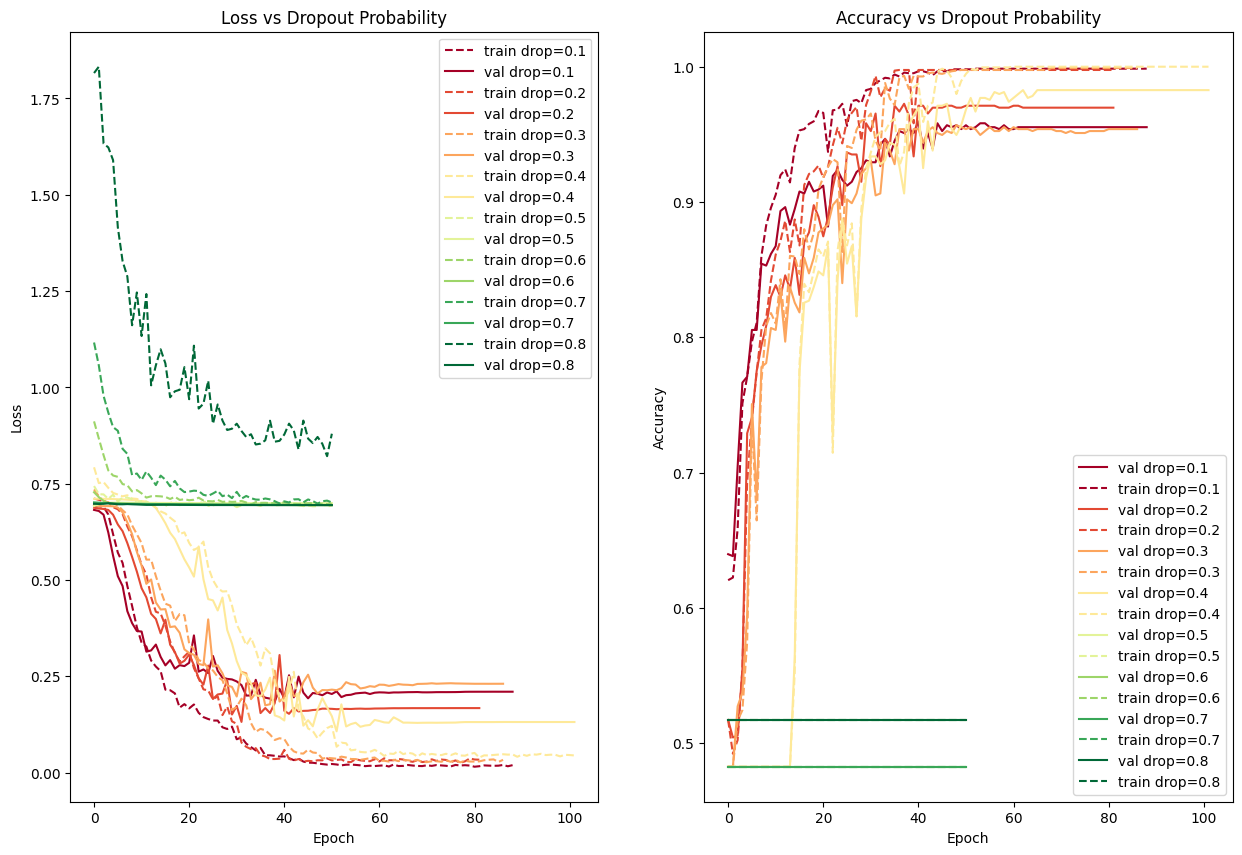

In [33]:
fig, axis = plt.subplots(1, 2, figsize=(15, 10))

# Define the color map
colors = cm.RdYlGn(np.linspace(0, 1, len(dropout_results)))

# Plotting the results with the Spectral color palette
for idx, result in enumerate(dropout_results):
    axis[0].plot(result['train_loss'], label=f"train drop={result['dropout_prob']}", linestyle='--', color=colors[idx])
    axis[0].plot(result['val_loss'], label=f"val drop={result['dropout_prob']}", color=colors[idx])
    axis[1].plot(result['validation_acc'], label=f"val drop={result['dropout_prob']}", color=colors[idx])
    axis[1].plot(result['training_acc'], label=f"train drop={result['dropout_prob']}", linestyle='--', color=colors[idx])

# Configure axis 0 (Loss plot)
axis[0].set_xlabel("Epoch")
axis[0].set_ylabel("Loss")
axis[0].set_title("Loss vs Dropout Probability")
axis[0].legend()

# Configure axis 1 (Accuracy plot)
axis[1].set_xlabel("Epoch")
axis[1].set_ylabel("Accuracy")
axis[1].set_title("Accuracy vs Dropout Probability")
axis[1].legend()

plt.show()


### Final Model - Tracking with Tensorboard

In [34]:
# %load_ext tensorboard

# %tensorboard --logdir runs

#%tensorboard --logdir=runs/ --host localhost --port 8088 # http://localhost:8088


In [35]:
dropout_prob = 0.4
# Instantiate model, criterion, optimizer, and TensorBoard writer
model = GaitGenderClassifier(dropout_prob)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()  # For binary classification without sigmoid in final layer
writer = SummaryWriter()

# Training the model
trained_model = training(model=model,
                          X_train=data_train_tensor,
                          y_train=target_train_tensor,
                          X_val=data_val_tensor,
                          y_val=target_val_tensor,
                          criterion=criterion,
                          optimizer=optimizer,
                          epochs=epochs,
                          writer=writer,
                          dropout_prob=dropout_prob,
                          log_tensorboard=True,
                          log_dropout=False,
                          verbose=True)

| Epoch 1 | Train Loss: 0.7285, Validation Loss: 0.6999 | Train Accuracy: 0.4827, Val Accuracy: 0.4827 |
| Epoch 20 | Train Loss: 0.6001, Validation Loss: 0.5522 | Train Accuracy: 0.8622, Val Accuracy: 0.8401 |
| Epoch 39 | Train Loss: 0.2803, Validation Loss: 0.1905 | Train Accuracy: 0.9616, Val Accuracy: 0.9452 |
| Epoch 58 | Train Loss: 0.1748, Validation Loss: 0.1707 | Train Accuracy: 0.9798, Val Accuracy: 0.9539 |
| Epoch 77 | Train Loss: 0.1394, Validation Loss: 0.1614 | Train Accuracy: 0.9870, Val Accuracy: 0.9582 |
| Epoch 96 | Train Loss: 0.1163, Validation Loss: 0.1624 | Train Accuracy: 0.9870, Val Accuracy: 0.9582 |
Early stopping at epoch 111
Best validation accuracy: 0.9597


In [36]:
from PIL import Image
def plot_image(name):
    img = Image.open(name)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

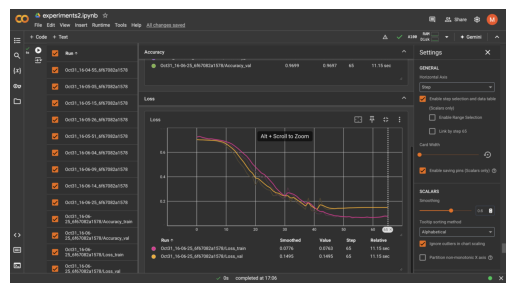

In [37]:
try:
    plot_image("/content/drive/MyDrive/HochschuleKiel/DeepLearning/Portfolio Exam/code/Tensorbaord - Loss.png")
except:
    plot_image("Tensorbaord - Loss.png")

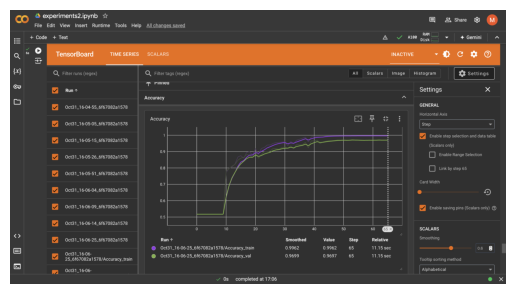

In [38]:
try:
    plot_image("/content/drive/MyDrive/HochschuleKiel/DeepLearning/Portfolio Exam/code/Tensorboard - Accuracy.png")
except:
    plot_image("Tensorboard - Accuracy.png")

### Evaluate the final Model

After the training we bring all the tensors back on cpu.

In [39]:
# bring tensor back to cpu
data_train_tensor = data_train_tensor.to('cpu')
data_test_tensor = data_test_tensor.to('cpu')
data_val_tensor = data_val_tensor.to('cpu')

target_train_tensor = target_train_tensor.to('cpu')
target_test_tensor = target_test_tensor.to('cpu')
target_val_tensor = target_val_tensor.to('cpu')

# also the model
model.to('cpu');

Next we evaluate the performance of the Deep Learning Model compared to the SVM and the Baseline.

In [40]:
results = add_results(results, "Deep Learning",
                      target_train_tensor,
                      model.predict(*get_data(data_train_tensor)),
                      target_val_tensor,
                      model.predict(*get_data(data_val_tensor)),
                      target_test_tensor,
                      model.predict(*get_data(data_test_tensor)))
display(results)

algorithm dataset  Accuracy     AUC
0       Baseline   train    51.729  50.000
1       Baseline     val    51.729  50.000
2       Baseline    test    51.799  50.000
3            SVM   train    92.988  92.886
4            SVM     val    92.795  92.617
5            SVM    test    93.381  93.300
6  Deep Learning   train    98.223  98.216
7  Deep Learning     val    95.965  95.921
8  Deep Learning    test    95.971  95.956

The Deep Learning model shows very high training accuracy and AUC, suggesting it effectively distinguishes between classes, though it may be slightly overfitted. On validation and test sets, its accuracy and AUC drop slightly, showing strong generalization. It outperforms the SVM across all datasets, with a 3–4% advantage on the test set, indicating a better ability to capture complex patterns.

## Conclusions and Future Work

### Conclusion
This project successfully demonstrates that gender classification based on gait cycle data is feasible, even with a relatively small sample size, and shows promising results in distinguishing between male and female subjects based on their individual gait cycles. The SVM model achieved strong performance, with around 93% accuracy and AUC on test data, while the Deep Learning model went further, achieving over 98% on training accuracy and around 96% accuracy and AUC on validation and test sets. These findings highlight the potential of deep learning in capturing complex, gender-related patterns in gait data with high reliability.

**Potential Limitations:**
- **Sample Size and Diversity**: With a limited number of subjects, there is a risk that the model has learned subject-specific patterns rather than generalized gender differences. A larger and more diverse dataset would improve generalization, focusing more on gender-related patterns rather than individual gait idiosyncrasies.
- **Model Complexity**: In this proof of concept, a simple neural network was used. Expanding data and resources will be crucial to build more sophisticated models with improved accuracy and reduced overfitting.

### Future Work
The promising results of this study suggest several directions for further research:
1. **Data Collection**: Expanding the dataset to include more subjects with varying ages and body types will enhance the model’s robustness and generalizability. A potential approach to improve generalization could be to split the training, validation, and test data based on unique subjects. For example, we could assign 50% of the subjects to the training set, 25% to the validation set, and 25% to the test set. To ensure balanced representation, it’s essential to have a roughly equal number of male and female subjects in each split.
   
2. **Model Optimization**: To address overfitting and improve performance, we could refine the deep learning model by exploring other architectures, such as [GRU-based](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html) RNNs, which are efficient and less prone to overfitting, especially with smaller datasets. Alternatively, [Conv1D-based](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html) CNNs may be effective for handling data with (N, features, gait cycles) shapes. Using hyperparameter optimization tools like Optuna could also help identify the best configurations. Stabalize the model by implementing [Normalizing Layers](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) into the model could be evaluated. Since the SVM machine learning algorithm achieved over 90% accuracy without fine-tuning, applying hyperparameter optimization could potentially push its accuracy even higher. This suggests that deep learning might not be necessary to achieve excellent performance. Feature reduction using e.g. PCA should also be explored. Since we have correlations between our features, this could lead to a strong increase in efficiency and decrease of computing time. 
   
3. **Feature Exploration**: Including features like speed and acceleration of each joint could uncover additional gait patterns, adding depth to the model's understanding of gender differences.
   
4. **Clinical Applications**: Testing the model in clinical trials could validate its potential for personalized assessments in therapeutic settings based on gait characteristics.

**Future Model Applications**:
Developing models that can classify individual subjects or detect injuries could open pathways for various applications beyond gender classification.

This study establishes a valuable foundation for future work in gait analysis and gender classification, with potential applications in clinical diagnostics, sports science, and security, highlighting the broader possibilities of gait-based assessment and monitoring.